# Pryngles module: Spangler

In [4]:
from pryngles import *

## External modules

In [5]:
import matplotlib.pyplot as plt
import numpy as np

#Plotting in 3d
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation
import math

## Spangler class

In [6]:
Spangler_doc=f"""\
    Fibonacci sampling of disks and spheres used to generate spangles position.
    This class and module is based on fibpy by Martin Roberts, source code: 
    https://github.com/matt77hias/fibpy
    
    Initialization attributes:
        N: integer:
            Number of spangles.
        
    Optional attibutes:
    
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the spangles for a given geometri will be 
            always the same.
        
    Secondary attributes:
    
        dim: integer. 
            Dimension of spangling.
            
        ss: numpy array (Nx3).
            Position of the spangles in cartesian coordinates, 
            
        pp: numpy array (Nx3).
            Position of the spangles in polar or spherical coordinates (r,theta,phi), 
            where theta is azimutal angle and phi is elevation (complement of polar angle).
            For 2-dimensional objects (circle and ring) only (r,theta) are provided.

            Notice that this convention is different than that of regular vectorial calculus
            where spherical coordinates are (r,theta,phi), but theta is the polar angle and phi 
            the ezimutal one.
            
        purged: boolean. default = False:
            Is the spangling purged?.  Purge is the process by which spangles too close are
            removed until the average distance between points is similar.
        
        dmin, dmed, dmax: float
            Minimum, median and maximum distance between spangles.
        
        ds: numpy array (N).
            Distance to the nearest neighbor for all the spangles.
            
        dran: float.
            Range of distances between spangles (dmax-dmin).  While the smaller this quantity the better.
            
        dstar: float.
            As measure of distances (sqrt(N)*dmed). Typically this value is between 2.4 and 3.4
            (see source http://extremelearning.com.au/evenly-distributing-points-on-a-sphere)

    Other attributes:
    
        cargs: dictionary.  default = dict(color="k",fill=False,alpha=0.3): 
            Arguments for plotting the circumference in polar.
                   
        wargs: dictionary. default = dict(color="k",lw=0.1): 
            Arguments for plotting a sphere in 3d space.
"""

In [7]:
class Spangler(object):
    def __init__(self,N=1000,seed=0):
        #Basic
        self.N=N
        self.seed=seed
        
        #Derivative
        self.dim=0
        self.ss=None
        self.pp=None
        self.dmin=self.dmed=self.dmax=self.dran=self.dstar=0
        
        #Purge
        self.purged=False
        
        #Plotting
        self.cargs=dict(color="k",fill=False,alpha=0.1) # 2d plot
        self.wargs=dict(color="k",lw=0.1) # 3d plot
        
        #Random seed
        self._seed_spangler()

    def _get_min_distance(self,r,rs):
        """
        Get the minimum distance from point r to points rs
        
        Parameter:
            r: numpy array (3):
                coordinates of the point.
            rs: numpy array (N)
                coordinates of the points.
        
        Return:
            dmin: float
                minimum distance.
        """
        deltas=rs-r
        dist=np.einsum('ij,ij->i',deltas,deltas)
        imin=np.argsort(dist)[1]
        return np.sqrt(dist[imin])

    def _calc_distances(self):
        """
        Calculate the minimum distances of all points in the sample.
        
        Update:
            ds,dmin,dmax,dmed,dran,dstar.
        """
        self.ds=np.array([self._get_min_distance(self.ss[i],self.ss) for i in range(len(self.ss))])
        self.dmin=self.ds.min()
        self.dmax=self.ds.max()
        self.dmed=np.median(self.ds)
        self.dran=self.dmax-self.dmin
        self.dstar=np.sqrt(self.N)*self.dmed
        
        #Area of each spangle
        self.aes=self.A/self.N

        #Effective diameter
        self.deff=2*(self.aes/np.pi)**0.5

    def _seed_spangler(self):
        if self.seed:
            np.random.seed(self.seed)
            
    def _pathpatch_2d_to_3d(self,pathpatch,pivot=[0,0,0],zDir=[0,0,1]):
        """
        Create a patch in 3d around pivot in the direction of zDir
        
        Source: https://stackoverflow.com/a/69785236
        """

        path = pathpatch.get_path() #Get the path and the associated transform
        trans = pathpatch.get_patch_transform()
        path = trans.transform_path(path) #Apply the transform

        pathpatch.__class__ =  mplot3d.art3d.PathPatch3D #Change the class
        pathpatch._path2d = path       #Copy the 2d path
        pathpatch._code3d = path.codes #Copy the codes
        pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color

        # Get the 2D vertices and add the third dimension
        verts3d = np.empty((path.vertices.shape[0],3))
        verts3d[:,0:2] = path.vertices
        verts3d[:,2] = pivot[2]

        #Get rotation matriz
        norm = np.linalg.norm(zDir)
        zDir = zDir/norm
        if np.abs(zDir[2])==1:
            yDir = np.array([0,zDir[2],0])
        else:
            yDir = (np.array([0,0,1]) - zDir[2]*zDir)/math.sqrt(1-zDir[2]**2)
        rotMat = np.empty((3,3))
        rotMat[:,0] = np.cross(zDir,yDir)
        rotMat[:,1] = yDir
        rotMat[:,2] = -zDir
        R=Rotation.from_matrix(rotMat)

        #Displace
        pathpatch._segment3d = R.apply(verts3d - pivot) + pivot

        return pathpatch

    # places a 3D circle in axes with 3d projection. 
    def _circle3d(self,center, radius, zDir='z', **kwargs):
        """
        Add a circle in 3d
        """
        pc = Circle(center[0:2], radius, **kwargs)
        self.ax.add_patch(self._pathpatch_2d_to_3d(pc, center, zDir))

In [28]:
def plot(self,spangled=dict(),**args):
    """
    Plot sample.

    Parameters:
        args: scatter plotting options, dictionary.
    """
    sargs=dict(c='k',s=1.5)
    sargs.update(args)
    
    #Spangles options
    if spangled:
        defaults=dict(alpha=0.3)
        defaults.update(spangled)
    
    if self.dim==2:            
        self.fig,self.ax=plt.subplots()
        self.ax.scatter(self.ss[:,0],self.ss[:,1],**sargs)
        self.ax.add_patch(plt.Circle((0,0),1,**self.cargs))
        self.ax.set_aspect("equal")
        if spangled:
            for isp in range(self.N):
                c=Circle(self.ss[isp],self.deff/2,**defaults)
                self.ax.add_patch(c)
                
    else:
        self.fig=plt.figure()
        self.ax=self.fig.add_subplot(111,projection='3d')
        self.ax.scatter(self.ss[:,0],self.ss[:,1],self.ss[:,2],**sargs)
        u,v=np.mgrid[0:2*np.pi:20j,0:np.pi:10j]
        x=np.cos(u)*np.sin(v)
        y=np.sin(u)*np.sin(v)
        z=np.cos(v)
        self.ax.plot_wireframe(x,y,z,**self.wargs)
        
        if spangled:
            for isp in range(self.N):
                self._circle3d(self.ss[isp],self.deff/2,zDir=self.ss[isp],**defaults)
        
        self.ax.set_box_aspect([1,1,1])
        
    self.fig.tight_layout()

Spangler.plot=plot

In [11]:
def gen_circle(self,perturbation=1,boundary=2):
    """
    Sample points in fibonacci spiral on the unit circle

    Optional parameters:

        perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int

        boundary: type of boundary (0 jagged, >1 smooth)

    Update:
        ss, pp
    """
    self._seed_spangler()
    
    #Unitary radius
    self.R=1

    #Total area
    self.A=np.pi*self.R**2
        
    shift = 1.0 if perturbation == 0 else self.N*np.random.random()

    ga = np.pi * (3.0 - np.sqrt(5.0))

    # Boundary points
    np_boundary = round(boundary * np.sqrt(self.N))

    self.dim=2
    self.ss = np.zeros((self.N,self.dim))
    self.pp = np.zeros((self.N,self.dim))
    j = 0
    for i in range(self.N):
        if i > self.N - (np_boundary + 1):
            r = 1.0
        else:
            r = np.sqrt((i + 0.5) / (self.N - 0.5 * (np_boundary + 1)))
        phi   = ga * (i + shift)
        self.ss[j,:] = np.array([r * np.cos(phi), r * np.sin(phi)])
        self.pp[j,:] = np.array([r,np.mod(phi,2*np.pi)])
        j += 1

    #Distances
    self._calc_distances()
    
Spangler.gen_circle=gen_circle

<IPython.core.display.Javascript object>


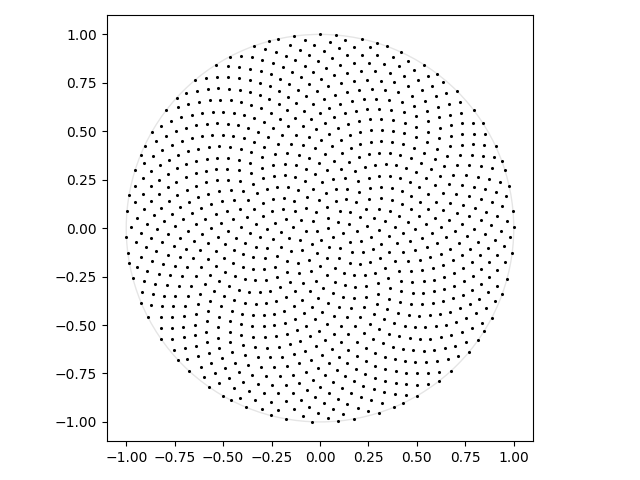

<IPython.core.display.Javascript object>


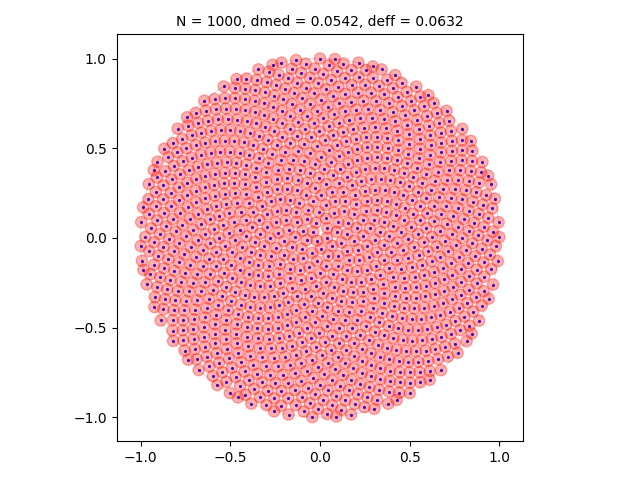

.
----------------------------------------------------------------------
Ran 1 test in 0.545s

OK


In [12]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_circle(self):

        #Generate circle
        S=Spangler(1000,seed=10)
        S.gen_circle()
        S.plot()
        S.plot(c='b',spangled=dict(color='r'))
        S.ax.set_title(f"N = {S.N}, dmed = {S.dmed:.4f}, deff = {S.deff:.4f}",fontsize=10)
        S.fig.tight_layout()
        
    class Test(unittest.TestCase):pass    
    Test.test_circle=test_circle
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [14]:
def gen_ring(self,gaps=[[0,0.5]],perturbation=1,boundary=2):
    """
    Sample points in fibonacci spiral on the unit circle, but including gaps (as in rings)

    Parameters:
        gaps: description of the position of gaps in the form [(R1,dR1),(R2,dR2),...], List of tuples.

    Optional parameters:
        perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
        boundary: type of boundary (0 jagged, >1 smooth)

    Example:
        s.Sample(1000)
        s.gen_circle_gaps([(0,0.2),(0.5,0.2),[0.8,0.1]])

    Update:
        ss, pp
    """
    self._seed_spangler()
    
    #Unitary radius
    self.R=1

    #Total area of the Sample
    self.A=np.pi*self.R**2
    for gap in gaps:
        aminus=np.pi*((gap[0]+gap[1])**2-gap[0]**2)
        self.A-=aminus

    shift = 1.0 if perturbation == 0 else self.N*np.random.random()
    ga = np.pi * (3.0 - np.sqrt(5.0))

    self.dim=2
    Ntest = self.N
    Nacc = 0

    while Nacc < self.N:        

        # Boundary points
        np_boundary = round(boundary * np.sqrt(Ntest))

        ss = []
        pp = []
        j = 0
        for i in range(Ntest):
            if i > Ntest - (np_boundary + 1):
                r = 1.0
            else:
                r = np.sqrt((i + 0.5) / (Ntest - 0.5 * (np_boundary + 1)))

            skip = False
            for gap in gaps:
                if gap[0]<=r<=(gap[0]+gap[1]):
                    skip = True
            if skip:continue

            phi   = ga * (i + shift)
            ss += [np.array([r * np.cos(phi), r * np.sin(phi)])]
            pp += [np.array([r,np.mod(phi,2*np.pi)])]
            j += 1
        Nacc = j
        Ntest += int((Ntest-Nacc)/len(gaps))

    self.ss=np.array(ss)
    self.pp=np.array(pp)
    self.N=Nacc

    #Distances
    self._calc_distances()
    
Spangler.gen_ring=gen_ring

0.004733096276594792
2.5132741228718345
2.513274122871835


<IPython.core.display.Javascript object>


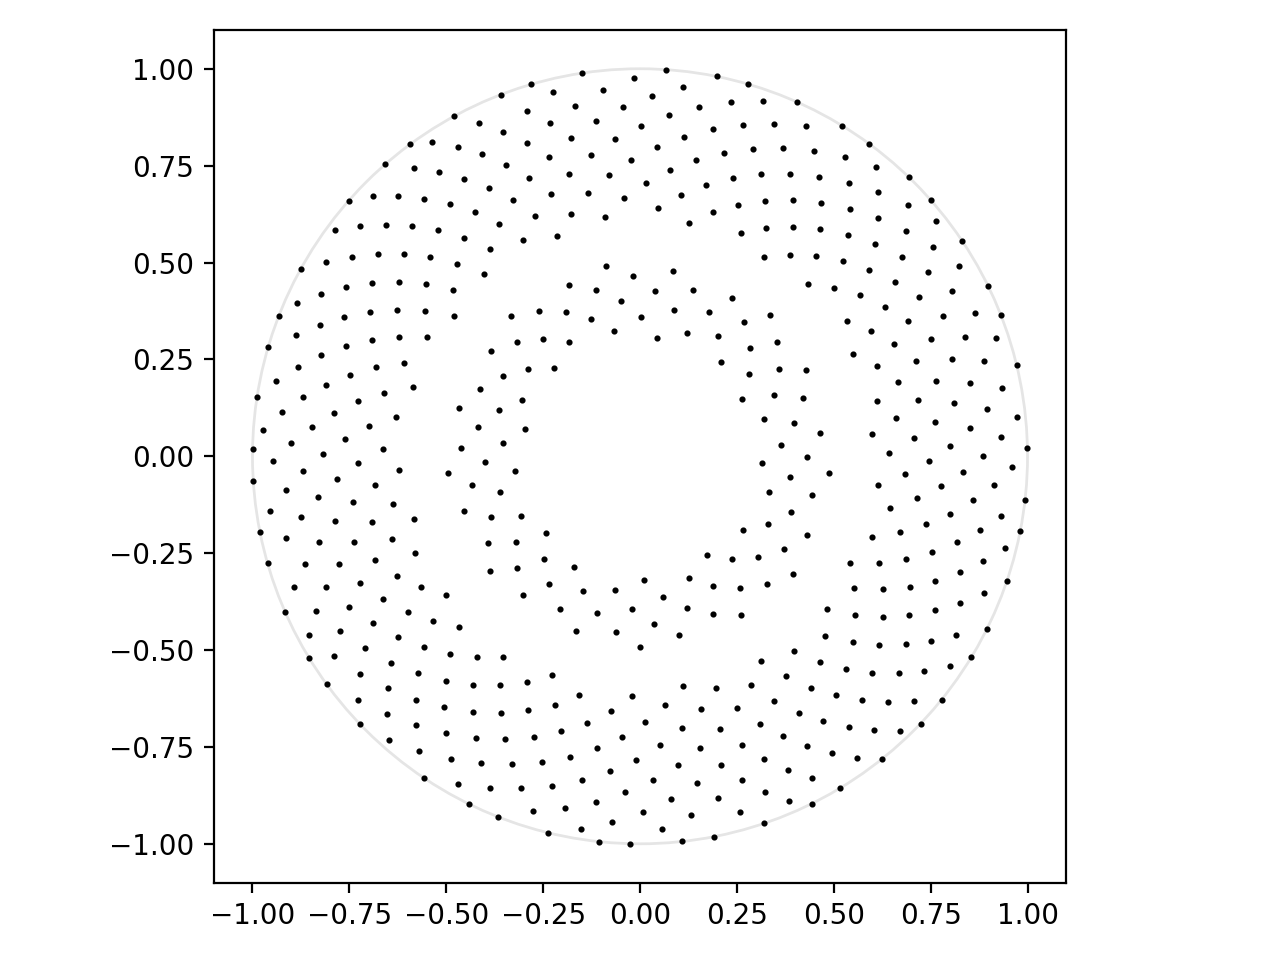

<IPython.core.display.Javascript object>


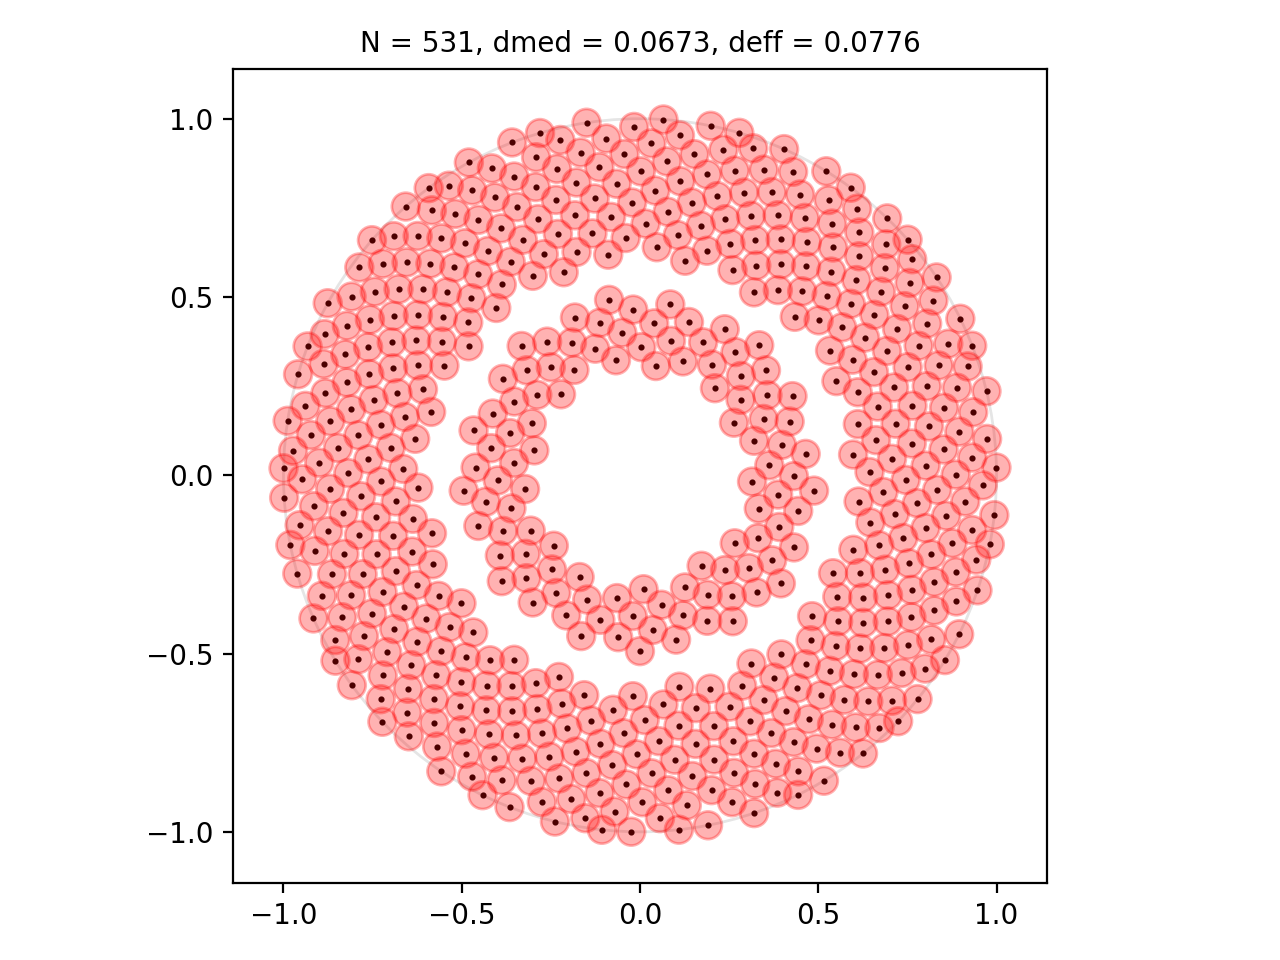

.
----------------------------------------------------------------------
Ran 1 test in 0.374s

OK


In [44]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_ring(self):

        #Generate rings
        S=Spangler(500,seed=10)
        S.gen_ring([[0.0,0.3],[0.5,0.1]])
        print(S.aes)
            
        #Test area
        print(S.A)
        print(np.pi*(1-0.3**2)-np.pi*(0.6**2-0.5**2))
    
        S.plot()
        S.plot(spangled=dict(color='r'))
        S.ax.set_title(f"N = {S.N}, dmed = {S.dmed:.4f}, deff = {S.deff:.4f}",fontsize=10)
        S.fig.tight_layout()

    class Test(unittest.TestCase):pass    
    Test.test_ring=test_ring
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [15]:
def gen_sphere(self,perturbation=1):
    """
    Sample points in the unit sphere following fibonacci spiral

    Optional parameters:
        perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int

    Update:
        ss, pp
    """
    self._seed_spangler()

    #Unitary radius
    self.R=1

    #Total area of the Sample
    self.A=4*np.pi*self.R**2

    shift = 1.0 if perturbation == 0 else self.N * np.random.random()

    ga = np.pi * (3.0 - np.sqrt(5.0))
    offset = 2.0 / self.N

    self.dim=3
    self.ss = np.zeros((self.N,self.dim))
    self.pp = np.zeros((self.N,self.dim))
    j = 0
    for i in range(self.N):
        phi   = ga * ((i + shift) % self.N)
        cos_phi = np.cos(phi)
        sin_phi = np.sin(phi)
        cos_theta = ((i + 0.5) * offset) - 1.0
        sin_theta = np.sqrt(1.0 - cos_theta*cos_theta)
        theta=np.arccos(cos_theta)            
        self.ss[j,:] = np.array([cos_phi * sin_theta, sin_phi * sin_theta, cos_theta])
        self.pp[j,:] = np.array([1,np.mod(phi,2*np.pi),np.pi/2-theta])
        j += 1

    #Distances
    self._calc_distances()

Spangler.gen_sphere=gen_sphere

<IPython.core.display.Javascript object>


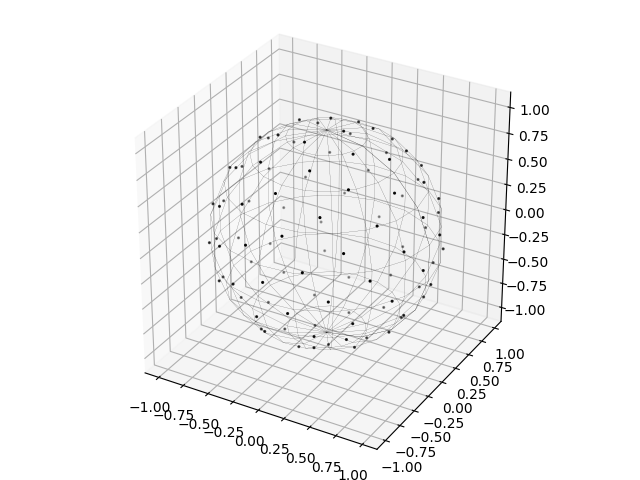

<IPython.core.display.Javascript object>


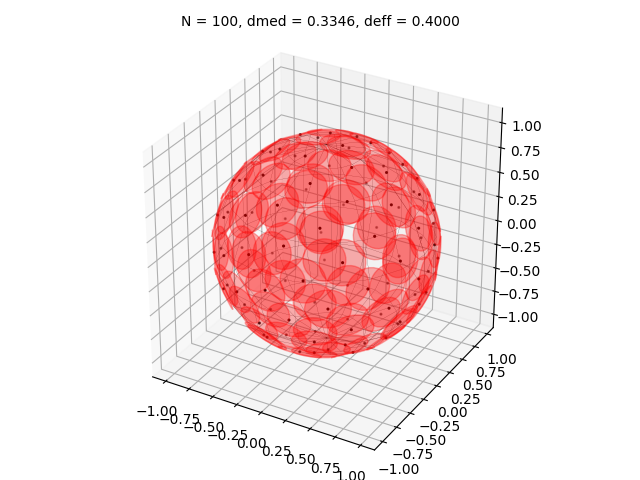

.
----------------------------------------------------------------------
Ran 1 test in 0.134s

OK


In [26]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_sphere(self):
        
        #Generate sphere
        S=Spangler(100,seed=10)
        S.gen_sphere()
        S.plot()
        S.plot(spangled=dict(color='r'))
        S.ax.set_title(f"N = {S.N}, dmed = {S.dmed:.4f}, deff = {S.deff:.4f}",fontsize=10)
        S.fig.tight_layout()
        
    class Test(unittest.TestCase):pass    
    Test.test_sphere=test_sphere
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [27]:
def purge_sample(self,tol=0.5):
    """
    Purge sample, ie. remove points close than a given threshold.

    Optional parameters:
        tol: distance to purge, ie. if dmin<tol*dmed then purge, float

    Update:
        ss, pp, N, _purge
    """
    if self.purged:
        print("Already purged.")
        return 0

    self.purged=False
    purge=True
    while purge:
        self._calc_distances()
        if self.dmin<tol*self.dmed:
            ipurge=np.argsort(self.ds)[0]
            self.ss=np.delete(self.ss,ipurge,0)
            self.pp=np.delete(self.pp,ipurge,0)
            self.N-=1
            self.purged=True
            purge=True
        else:
            purge=False

Spangler.purge_sample=purge_sample

<IPython.core.display.Javascript object>


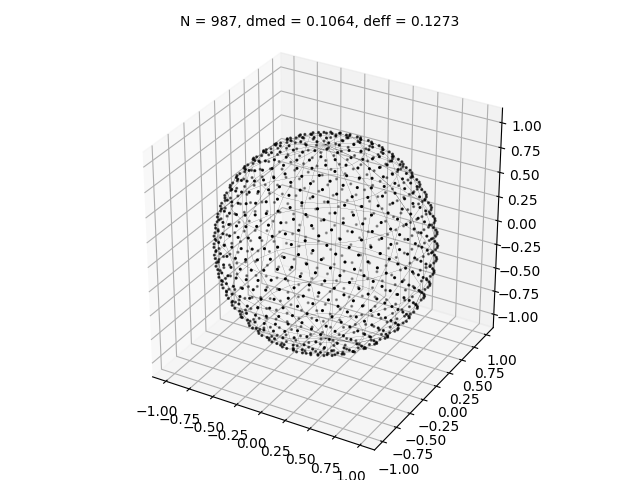

.
----------------------------------------------------------------------
Ran 1 test in 0.942s

OK


In [35]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_purge(self):
        
        #Generate sphere
        S=Spangler(1000,seed=10)
        S.gen_sphere()
        S.purge_sample()
        S.plot()
        S.ax.set_title(f"N = {S.N}, dmed = {S.dmed:.4f}, deff = {S.deff:.4f}",fontsize=10)
        S.fig.tight_layout()
        
    class Test(unittest.TestCase):pass    
    Test.test_purge=test_purge
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [24]:
Spangler.__doc__=Spangler_doc

--End--